In [45]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [46]:
# Load in the words and randomly shuffle our dataset for training
words = open('names.txt', 'r').read().splitlines()
random.shuffle(words)

# Get a set of all characters, the characte to integer conversion and integer to character conversion functions
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [47]:
# Dataset building
# Take 8 characters of context and we can predcict the sequence
block_size = 8

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte,  Yte  = build_dataset(words[n2:])

In [48]:
# Matrix multiplication in the forward direction

# Takes input x multiplies it by a weight adn optionally adds a bias
# so if we have a 4, 80 input @ 80, 200  gives a 4, 200 - the bias is then broadcast to all of the values within the 4, 200 
# These dimensions in pytorch still work even if our input is 4, 5, 80 then we get 4, 5, 200 - it only works on the last dimension and everything else is just a batch dimension
# The matrix multiplication is only done on the last dimension and thus the rest does not matter
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    # Kaiming intialisation of our linear layer with Root(fan in) as the normalisation constant
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [49]:
# Running mean and variances, trained using an exponential moving average during the forward pass
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

In [50]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [51]:
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

In [52]:
# We want to create batch dimensions within the wavenet to carry out the calculations in parallel
# 4, 80 @ 80, 200 
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

In [53]:
# containers in pytorch maintain a list of layers
# we take the input and call all teh layers sequentially and return out result
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [54]:
vocab_size = len(chars) + 1

# WaveNet
n_embd = 24                                               
n_hidden = 128

# Our model is a sequential layer
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) 
for p in parameters:
  p.requires_grad = True

76579


In [55]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3040
  10000/ 200000: 1.6289
  20000/ 200000: 2.2088
  30000/ 200000: 2.1255
  40000/ 200000: 1.9016
  50000/ 200000: 1.7379
  60000/ 200000: 1.6664
  70000/ 200000: 1.8457
  80000/ 200000: 1.6029
  90000/ 200000: 1.9586
 100000/ 200000: 2.1804
 110000/ 200000: 1.7679
 120000/ 200000: 2.2814
 130000/ 200000: 1.7521
 140000/ 200000: 1.8637
 150000/ 200000: 1.9317
 160000/ 200000: 2.1788
 170000/ 200000: 2.6222
 180000/ 200000: 1.4166
 190000/ 200000: 1.5557


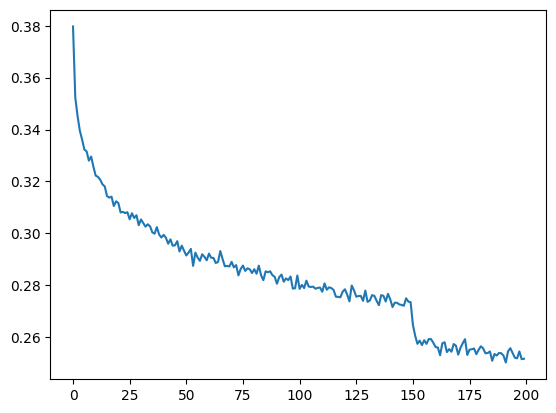

In [61]:
# 32 batch elements are too  few so it creates a very thick function

# we can .view it so that we take the average of 1000 elements within each row - this is very helpful as this means that we can take teh meaan of every row
# and we can see something mucch nicer
# The -1 here in .view() representing that pytorhc will figure out the value needed
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

# The learning rate decay allowed us to settle very quickly and is shown by the dip within the graph

In [62]:
# We need to remember that after using batch normalisation layers the running average that is being accumulated during training
# should no longer be updated whenever being used for evaluation/inference and thus we need to make sure that the average is being used not updated
for layer in model.layers:
  layer.training = False

In [63]:
# Disable gradient tracking whenever we are going through the loss
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7702031135559082
val 1.9887281656265259


In [59]:
"""
- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993
"""

'\n- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105\n- context: 3 -> 8 (22K params): train 1.918, val 2.027\n- flat -> hierarchical (22K params): train 1.941, val 2.029\n- fix bug in batchnorm: train 1.912, val 2.022\n- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993\n'

In [66]:
# Sampling
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

julie.
pere.
drae.
rshy.
zylon.
hier.
acea.
kaydina.
danely.
abdyanah.
daiah.
lara.
nalia.
kelilah.
jalon.
kobey.
lilyanna.
kattlin.
aceni.
kimo.
